<a href="https://colab.research.google.com/github/mkhfring/cosc419-notes/blob/main/gradient_decent_second_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [27]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [28]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

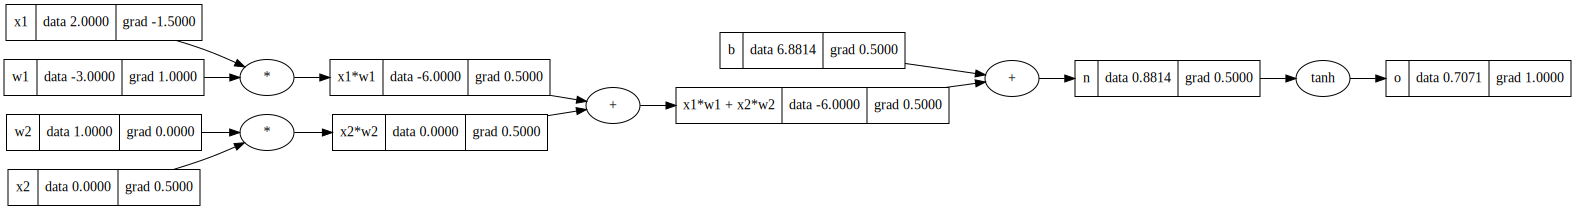

In [29]:
draw_dot(o)

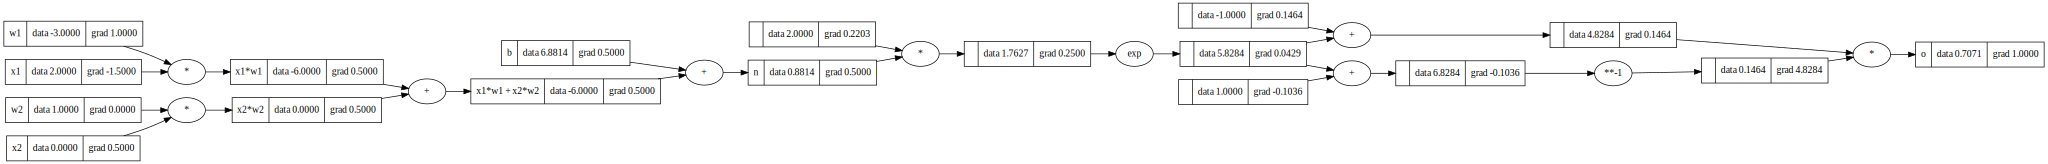

In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [21]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
a = torch.tensor([[1,2,3], [4,5,6]])
a.shape

torch.Size([2, 3])

In [ ]:
a =[1, 3, 4]
b = [6, 7, 9]
for i, j in zip(a, b):
  print(i, j)

1 6
3 7
4 9


In [52]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return 0.0




In [53]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

[Value(data=-0.8320069357058513), Value(data=0.9150345814267353)]


0.0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random


class PyNeuron:

  def __init__(self, nin):
    self.w = torch.randn(nin, requires_grad=True)  # Randomly initialize weights
    self.b = torch.randn(1, requires_grad=True)

  def __call__(self, x):
    # w * x + b
    act = torch.dot(self.w, x) + self.b  # Linear transformation
    out = torch.tanh(act)                # Apply tanh activation
    return out



In [ ]:
x = torch.tensor([2.0, 3.0])
n = PyNeuron(2)
n(x)


tensor([0.5945], grad_fn=<TanhBackward0>)

In [57]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
    # self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]

    # outs = [n(x) for n in self.neurons]
    return outs



In [58]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.713249969669989),
 Value(data=0.7667227917220356),
 Value(data=-0.9941614112695731)]

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class PyNeuron:

  def __init__(self, nin):
    # Initialize weights and bias using torch
    self.w = torch.randn(nin, requires_grad=True)  # Randomly initialize weights
    self.b = torch.randn(1, requires_grad=True)    # Randomly initialize bias

  def __call__(self, x):
    # w * x + b
    act = torch.dot(self.w, x) + self.b  # Linear transformation
    out = torch.tanh(act)                # Apply tanh activation
    return out

  def parameters(self):
    return [self.w, self.b]

class PyLayer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

In [64]:
x = torch.tensor([2.0, 3.0])
n = PyLayer(2, 3)
n(x)


[Value(data=0.9833844948633461),
 Value(data=0.9572910532519261),
 Value(data=-0.9077025441085537)]

In [65]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [67]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9613767958730898)

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class PyNeuron:

  def __init__(self, nin):
    # Initialize weights and bias using torch
    self.w = torch.randn(nin, requires_grad=True)  # Randomly initialize weights
    self.b = torch.randn(1, requires_grad=True)    # Randomly initialize bias

  def __call__(self, x):
    # w * x + b
    act = torch.dot(self.w, x) + self.b  # Linear transformation
    out = torch.tanh(act)                # Apply tanh activation
    return out

  def parameters(self):
    return [self.w, self.b]

class PyLayer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

class PyMLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [PyLayer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x



In [70]:
x = torch.tensor([2.0, 3.0])
n = PyMLP(3, [4,4,1])
n(x)

[Value(data=-0.2732933517695136)]

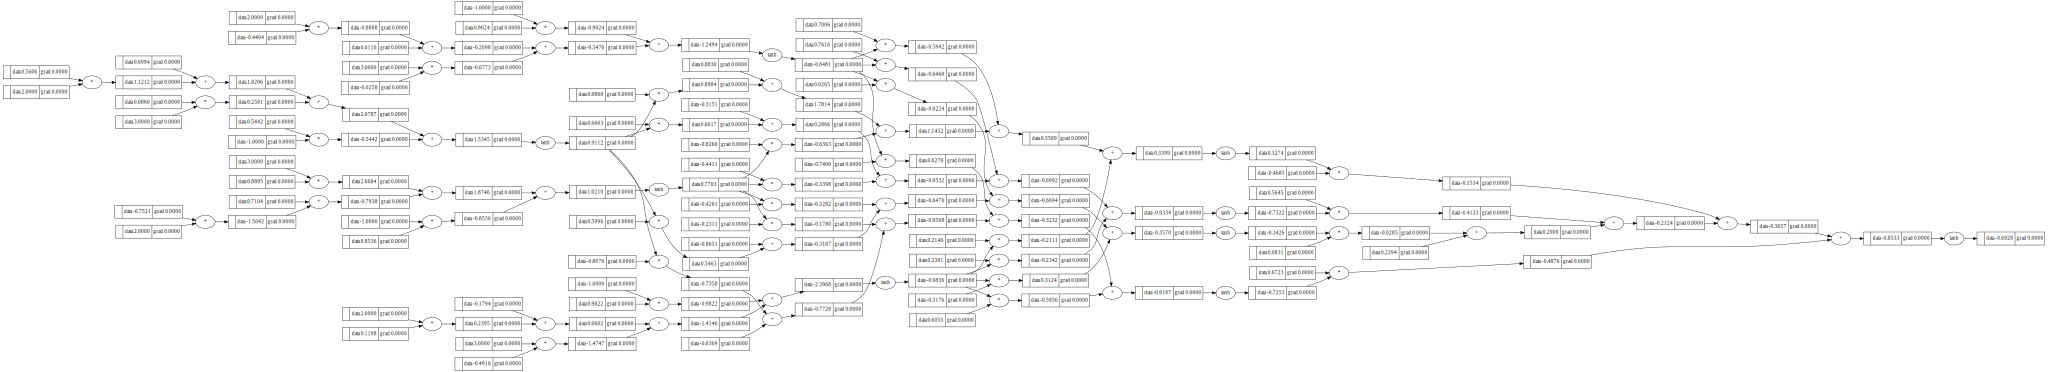

In [ ]:
draw_dot(n(x))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class Neuron:

  def __init__(self, nin):
    # Initialize weights and bias using torch
    self.w = torch.randn(nin, requires_grad=True)  # Randomly initialize weights
    self.b = torch.randn(1, requires_grad=True)    # Randomly initialize bias

  def __call__(self, x):
    # w * x + b
    act = torch.dot(self.w, x) + self.b  # Linear transformation
    out = torch.tanh(act)                # Apply tanh activation
    return out

  def parameters(self):
    return [self.w, self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # Collect all parameters (weights and biases) of neurons in the layer
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    # Forward pass through each layer
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    # Collect all parameters (weights and biases) from each layer
    return [p for layer in self.layers for p in layer.parameters()]

SyntaxError: invalid syntax (<ipython-input-11-f54bf5cc0adc>, line 1)

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.16578526021381612)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:

for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)


0 0.002056123958292787
1 0.0020404768419831024
2 0.0020250564320649566
3 0.002009857924015696
4 0.001994876646733686
5 0.0019801080579702683
6 0.001965547739947282
7 0.0019511913951512907
8 0.0019370348422964524
9 0.0019230740124479978
10 0.001909304945299319
11 0.0018957237855951486
12 0.0018823267796946328
13 0.0018691102722676993
14 0.0018560707031189828
15 0.0018432046041333716
16 0.0018305085963379896
17 0.0018179793870754363
18 0.0018056137672833098
19 0.0017934086088756394


In [ ]:
ypred

[Value(data=0.9817830812439714),
 Value(data=-0.9863881624765284),
 Value(data=-0.9766534529377958),
 Value(data=0.9729591216966093)]